In [ ]:
# @title Import Requirements
from IPython.display import clear_output
import os
import io
import gc
import random
import nltk

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tsnecuda import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

import tensorflow as tf
from tqdm.notebook import tqdm

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from transformers import (
    BertConfig,
    BertTokenizer,
    TFBertForSequenceClassification
)

SELECTED_GPU = 1
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_visible_devices(gpus[SELECTED_GPU], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[SELECTED_GPU], True)
    print(gpus[SELECTED_GPU])
  except RuntimeError as e:
    print(e)


PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [ ]:
fdir = '/home/username/NLP/Data/SentEval/data/probing/'
BATCH_SIZE = 256
MAX_LENGTH = 48

TASK_NAME = 'coordination_inversion.txt'

CLASSIFIER_MODEL_FPATH = '/home/username/NLP/Models/SentEvalAnalysis/BERT_AVG_Classifiers/'

pretrained_loc = "bert-base-uncased"
print("Running with:", pretrained_loc)

Running with: bert-base-uncased


In [ ]:
# @title Required Functions & Classes
def load_probing_data(fpath, additive=''):
    task_data = {'train': {'X': [], 'y': []},
                 'dev': {'X': [], 'y': []},
                 'test': {'X': [], 'y': []}}


    tok2split = {'tr': 'train', 'va': 'dev', 'te': 'test'}
    with io.open(fpath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.rstrip().split('\t')
            task_data[tok2split[line[0]]]['X'].append(additive + line[-1])
            task_data[tok2split[line[0]]]['y'].append(line[1])

        if fpath == '~/NLP/Data/SentEval/data/probing/tree_depth.txt':
            labels = ['5', '6', '7', '8', '9', '10', '11']
            tok2label = dict(zip(labels, [0, 1. / 6, 2. / 6, 3. / 6, 4. / 6, 5. / 6, 1]))
        else:
            labels = sorted(np.unique(task_data['train']['y']))
            tok2label = dict(zip(labels, range(len(labels))))
        nclasses = len(tok2label)

        for split in task_data:
            for i, y in enumerate(task_data[split]['y']):
                task_data[split]['y'][i] = tok2label[y]

    return task_data, tok2label, nclasses

class BertReprProbing(tf.keras.Model):
    def __init__(self, bert_model, **kwargs):
        super(BertReprProbing, self).__init__(name="BertReprProbing")
        self.bert = bert_model

    def call(self, inputs, **kwargs):
        middle_hidden_states = self.bert(inputs, **kwargs)[2]
        output = []
        for i in range(1, 13):
            output.append(middle_hidden_states[i])
        return tf.stack(output)

@tf.function
def tf_average(hidden_states, att_mask, w):
  max_length = tf.cast(tf.shape(att_mask)[1], tf.float32)
  att_mask = tf.cast(att_mask[:, 1:], tf.float32)
  avg = tf.reshape(tf.matmul(tf.transpose(hidden_states[:, 1:] * tf.expand_dims(att_mask, axis=-1), perm=[0, 2, 1]), w), (-1, 768))
  avg = avg * tf.cast((max_length - 1.0) / tf.reduce_sum(att_mask, axis=-1, keepdims=True), tf.float32)
  return avg

In [ ]:
# @title Load BERT Model
config = BertConfig.from_pretrained(pretrained_loc, output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
loaded_model = TFBertForSequenceClassification.from_pretrained(pretrained_loc,
                                                               config=config)

probing_model = BertReprProbing(loaded_model.bert)
clear_output()
print("Done!")

Done!


In [ ]:
#@title Probe Feature Extraction (Total)
probe_path = fdir + TASK_NAME
task_data, tok2label, nclasses = load_probing_data(probe_path)
print("Probe Loaded:", TASK_NAME)

del task_data['train']
del task_data['dev']
gc.collect()


n_total_examples = len(task_data['test']['X'])
total_steps = int(np.ceil(n_total_examples / BATCH_SIZE))

total_hidden_representations = np.zeros((12, n_total_examples, MAX_LENGTH, 768), dtype=np.float32)
total_token_ids = np.zeros((n_total_examples, MAX_LENGTH), dtype=np.int32)
total_att_masks = np.zeros((n_total_examples, MAX_LENGTH), dtype=np.int32)

print("Starting probe feature extraction:", TASK_NAME)

for i in tqdm(range(total_steps)):
    tokens_batched = tokenizer.batch_encode_plus(task_data['test']['X'][i * BATCH_SIZE:min((i + 1) * BATCH_SIZE, n_total_examples)],
                                                 max_length=MAX_LENGTH,
                                                 return_tensors='tf',
                                                 truncation=True,
                                                 padding='max_length')
    
    total_hidden_representations[:,
    i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :] = probing_model(tokens_batched, training=False).numpy()

    total_att_masks[i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :] = tokens_batched['attention_mask']
    total_token_ids[i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :] = tokens_batched['input_ids']                                 

Probe Loaded: coordination_inversion.txt
Starting probe feature extraction: coordination_inversion.txt


In [ ]:
# @title Probe Feature Extraction Pruned 

probe_path = fdir + TASK_NAME
task_data, tok2label, nclasses = load_probing_data(probe_path)
print("Probe Loaded:", TASK_NAME)
del task_data['train']
del task_data['dev']
gc.collect()

# Prune Dataset
org_data = []
inv_data = []

for row in zip(task_data['test']['X'], task_data['test']['y']):
  example, label = row

  if label == 1: #1: original 0:inverted
    continue

  if "Andra" in example or "hide-and-seek" in example or "blue-and-white" in example:
    continue

  chunked = example.split()

  if "but" not in chunked and "and" not in chunked:
    continue

  # hand code BEGIN
  if chunked[-2] == ',':
    continue
  if np.sum(np.array(tokenizer.encode(example)) == tokenizer.convert_tokens_to_ids('.')) > 1:
    continue
  # hand code END

  if "but" in chunked:
    inv_pos = chunked.index("but")
  elif "and" in chunked:
    inv_pos = chunked.index("and")
  
  if chunked[inv_pos-1] == ",":
    inverted_chunked = chunked[inv_pos+1:-1] + chunked[inv_pos-1:inv_pos+1] + chunked[:inv_pos-1] + [chunked[-1]]
  else:
    inverted_chunked = chunked[inv_pos+1:-1] + [chunked[inv_pos]] + chunked[:inv_pos] + [chunked[-1]]
  
  org_chunked = ' '.join(chunked)
  inverted_chunked = ' '.join(inverted_chunked)

  org_data.append(inverted_chunked)
  inv_data.append(org_chunked)
    

n_examples = len(org_data)
steps = int(np.ceil(n_examples / BATCH_SIZE))


org_hidden_representations = np.zeros((12, n_examples, MAX_LENGTH, 768), dtype=np.float32)
inv_hidden_representations = np.zeros((12, n_examples, MAX_LENGTH, 768), dtype=np.float32)
org_token_ids = np.zeros((n_examples, MAX_LENGTH), dtype=np.int32)
inv_token_ids = np.zeros((n_examples, MAX_LENGTH), dtype=np.int32)
att_masks = np.zeros((n_examples, MAX_LENGTH), dtype=np.int32)
att_masks = np.zeros((n_examples, MAX_LENGTH), dtype=np.int32)

org_positions = np.zeros(n_examples, dtype=np.int32)
inv_positions = np.zeros(n_examples, dtype=np.int32)

print("Starting probe feature extraction:", TASK_NAME)

for i in tqdm(range(steps)):
  # original examples
  tokens_batched = tokenizer.batch_encode_plus(org_data[i * BATCH_SIZE:min((i + 1) * BATCH_SIZE, n_examples)],
                                                max_length=MAX_LENGTH,
                                                return_tensors='tf',
                                                truncation=True,
                                                padding='max_length')
  
  input_ids = tokens_batched['input_ids'].numpy()
  attention_mask = tokens_batched['attention_mask'].numpy()

  cond_but = (input_ids == tokenizer.convert_tokens_to_ids("but"))
  cond_and = (input_ids == tokenizer.convert_tokens_to_ids("and"))
  org_positions[i * BATCH_SIZE:(i + 1) * BATCH_SIZE] = np.where(np.logical_or(cond_but, cond_and) == True)[1]

  org_hidden_representations[:,
  i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :] = probing_model(tokens_batched, training=False).numpy()

  org_token_ids[i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :] = input_ids
  att_masks[i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :] = attention_mask


  # inverted examples
  tokens_batched = tokenizer.batch_encode_plus(inv_data[i * BATCH_SIZE:min((i + 1) * BATCH_SIZE, n_examples)],
                                                max_length=MAX_LENGTH,
                                                return_tensors='tf',
                                                truncation=True,
                                                padding='max_length')
  
  input_ids = tokens_batched['input_ids'].numpy()

  cond_but = (input_ids == tokenizer.convert_tokens_to_ids("but"))
  cond_and = (input_ids == tokenizer.convert_tokens_to_ids("and"))
  inv_positions[i * BATCH_SIZE:(i + 1) * BATCH_SIZE] = np.where(np.logical_or(cond_but, cond_and) == True)[1]

  inv_hidden_representations[:,
  i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :] = probing_model(tokens_batched, training=False).numpy()

  inv_token_ids[i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :] = input_ids


Probe Loaded: coordination_inversion.txt
Starting probe feature extraction: coordination_inversion.txt


In [ ]:
# @title Importance Computation 2 Function
def compute_importance(n_examples, hidden_representations, att_masks, label):
  saliances = np.zeros((12, n_examples, nclasses, MAX_LENGTH))
  gold_importance = np.empty((12, n_examples, MAX_LENGTH))
  weights = tf.Variable(np.ones((MAX_LENGTH-1, 1)) / (MAX_LENGTH-1), dtype=tf.float32, trainable=True)
  pred_labels = np.zeros((12, n_examples))
  accuracy = np.zeros(12)

  BATCH_SIZE = 128
  steps = int(np.ceil(n_examples / BATCH_SIZE))
  for i in range(12):
    # print("Load classifier", i)
    classifier = tf.keras.models.load_model(CLASSIFIER_MODEL_FPATH + TASK_NAME[:-4] + '/' + str(i))
    acc = 0.0
    for j in range(steps):
      with tf.GradientTape() as tape:
        avgs = tf_average(hidden_representations[i, j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :, :],
                          att_masks[j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :], weights)
        probs = classifier(avgs)[:, 0]
      grads = tape.gradient(probs, avgs)
      pred_labels[i, j * BATCH_SIZE:(j + 1) * BATCH_SIZE] = probs < 0.5
      salience_scores = tf.expand_dims(grads, axis=1) * hidden_representations[i, j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :, :] * tf.cast(tf.expand_dims(att_masks[j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :], axis=-1), dtype=tf.float32)
      saliances[i][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, 0, 1:] = tf.reduce_sum(salience_scores, axis=-1).numpy()[:, 1:]
      saliances[i][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, 1, 1:] = -saliances[i][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, 0, 1:]
      
      acc += np.mean(pred_labels[i, j * BATCH_SIZE:(j + 1) * BATCH_SIZE] == label[j * BATCH_SIZE:(j + 1) * BATCH_SIZE])
      # importance[i][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :, 1:] = tf.squeeze(grads, axis=-1)
      # rep_importance[i][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :] = grads_rep_based
    # print(acc / steps)
    accuracy[i] = acc / steps

  
  for i in range(n_examples):
    gold_importance[:, i] = saliances[:, i, label[i]]
  return saliances, gold_importance, accuracy, pred_labels
      

In [ ]:
#@title Importance Computation 2
# saliances, gold_importance, accuracy, pred_labels = compute_importance(n_examples*2, np.concatenate([org_hidden_representations, inv_hidden_representations], axis=1), np.repeat(att_masks, 2, axis=0), np.concatenate([np.ones(n_examples, dtype=np.int8), np.zeros(n_examples, dtype=np.int8)]))
saliances, gold_importance, accuracy, pred_labels = compute_importance(n_total_examples, total_hidden_representations, total_att_masks, task_data['test']['y'])


In [ ]:
#@title Unique Tokens
# unique_tokens, token_inverse, token_counts = np.unique(org_token_ids, return_counts=True, return_inverse=True)
unique_tokens, token_inverse, token_counts = np.unique(total_token_ids, return_counts=True, return_inverse=True)


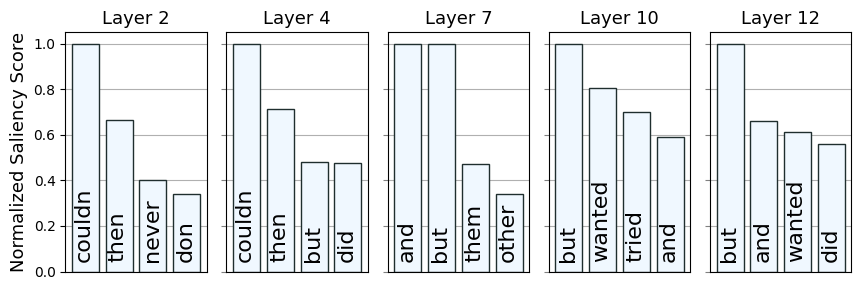

In [ ]:
# @title Top importance words 5-Layer
TOP_TOKENS_TO_SHOW = 4
import matplotlib
fig = plt.figure(figsize = (20,3), dpi=100)
# fig.subplots_adjust(wspace=0.05)
top_tokens = np.argwhere(token_counts > 128)[2:].flatten()
cmap = matplotlib.cm.get_cmap('summer')
top_imps = []
max_importance_per_layer = []
for l_idx, layer_num in enumerate([1,3,6,9,11]):
  top_tokens_importances = []
  for i in top_tokens:
    mean_imp = np.mean(gold_importance[layer_num][total_token_ids == unique_tokens[i]])
    top_tokens_importances.append(mean_imp)
  labels = []
  imps = []
  top_tokens_importances = np.array(top_tokens_importances)
  top_imps.append(top_tokens_importances)
  for i in reversed(np.argsort(top_tokens_importances)[-TOP_TOKENS_TO_SHOW:]):
    labels.append(tokenizer.decode([unique_tokens[top_tokens[i]]]))
    imps.append(top_tokens_importances[i])
  max_importance_per_layer.append(np.max(imps))
  
  ax = fig.add_subplot(1, 12, l_idx+1, fc='#FFFFFF')
  ax.grid('on', axis='y')
  ax.set_axisbelow(True)
  ax.bar(np.arange(TOP_TOKENS_TO_SHOW), imps / np.max(imps), align='center', color='aliceblue', edgecolor='#1f2e2e', linewidth=1)
  for i, (p, pr) in enumerate(zip(labels, imps)):
    ax.text(s=p, x=i-TOP_TOKENS_TO_SHOW/12, y=0.06, color='k', size=16, rotation=90, weight=500)
  ax.set_xticks([])
  if l_idx != 0:
    ax.tick_params(axis='y', colors='gray')
    ax.set_yticklabels([])
  else:
    ax.set_ylabel('Normalized Saliency Score', size=13)
  ax.set_title('Layer ' + str(layer_num + 1), size=13)
  # ax.set(frame_on=False)
fig.tight_layout()
plt.show()

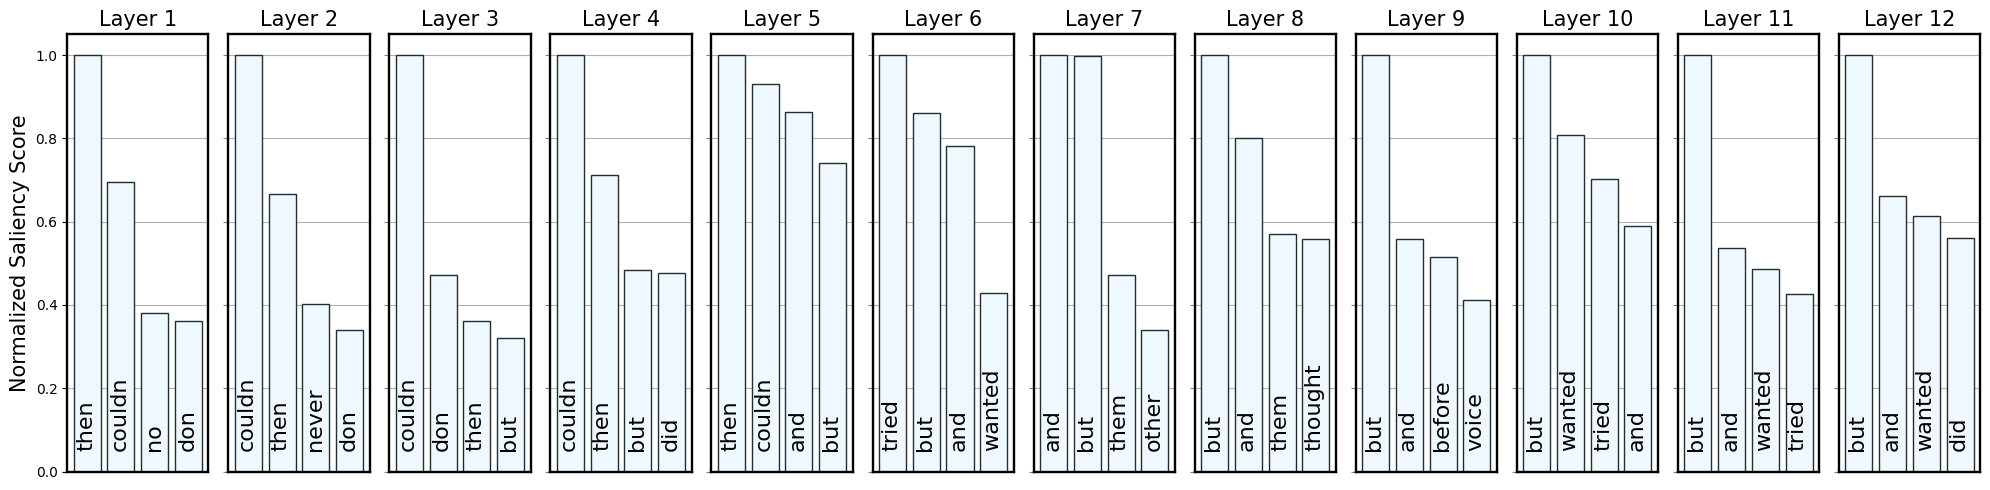

In [ ]:
# @title Top importance words 
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.7 #set the value globally
TOP_TOKENS_TO_SHOW = 4
import matplotlib
fig = plt.figure(figsize = (20,5), dpi=100)
top_tokens = np.argwhere(token_counts > 128)[2:].flatten()
cmap = matplotlib.cm.get_cmap('summer')
top_imps = []
max_importance_per_layer = []
for l_idx, layer_num in enumerate(range(12)):
  top_tokens_importances = []
  for i in top_tokens:
    mean_imp = np.mean(gold_importance[layer_num][total_token_ids == unique_tokens[i]])
    top_tokens_importances.append(mean_imp)
  labels = []
  imps = []
  top_tokens_importances = np.array(top_tokens_importances)
  top_imps.append(top_tokens_importances)
  for i in reversed(np.argsort(top_tokens_importances)[-TOP_TOKENS_TO_SHOW:]):
    labels.append(tokenizer.decode([unique_tokens[top_tokens[i]]]))
    imps.append(top_tokens_importances[i])
  max_importance_per_layer.append(np.max(imps))
  
  ax = fig.add_subplot(1, 12, l_idx+1, fc='#FFFFFF')
  ax.grid('on', axis='y')
  ax.set_axisbelow(True)
  ax.bar(np.arange(TOP_TOKENS_TO_SHOW), imps / np.max(imps), align='center', color='aliceblue', edgecolor='#1f2e2e', linewidth=1)
  for i, (p, pr) in enumerate(zip(labels, imps)):
    ax.text(s=p, x=i-TOP_TOKENS_TO_SHOW/12, y=0.06, color='k', size=16, rotation=90, weight=500)
  ax.set_xticks([])
  if l_idx != 0:
    ax.tick_params(axis='y', colors='gray')
    ax.set_yticklabels([])
  else:
    ax.set_ylabel('Normalized Saliency Score', size=15)
  ax.set_title('Layer ' + str(layer_num + 1), size=15)
  # ax.set(frame_on=False)
fig.tight_layout()
plt.show()

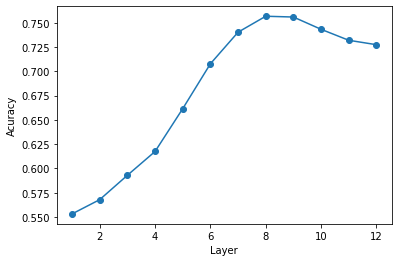

In [ ]:
plt.plot(range(1, 13), accuracy, label="all", marker="o")
# plt.legend()
plt.xlabel("Layer")
plt.ylabel("Acuracy")
plt.show()

##Similarities

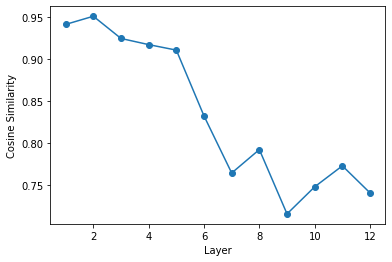

In [ ]:
# @title BUT Similarities
but_sim = []
for layer in range(12):
  sim_one_layer = []
  for ex in range(n_examples):
    if org_token_ids[ex][org_positions[ex]] == tokenizer.convert_tokens_to_ids('but'):
      X = org_hidden_representations[layer][ex][org_positions[ex]]
      Y = inv_hidden_representations[layer][ex][inv_positions[ex]]
      sim_one_layer.append(cosine_similarity(X.reshape(1 , -1), Y.reshape(1 , -1)).item())
  but_sim.append(sim_one_layer)

but_sim = np.array(but_sim)
but_sim = np.mean(but_sim, axis=1)

plt.plot(range(1, 13), but_sim, marker="o")
plt.xlabel("Layer")
plt.ylabel("Cosine Similarity")
plt.show()

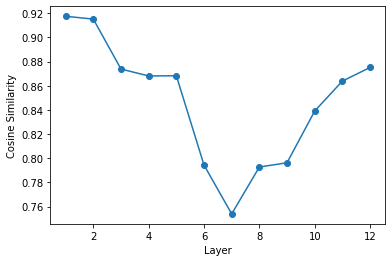

In [ ]:
# @title AND Similarities
and_sim = []
for layer in range(12):
  sim_one_layer = []
  for ex in range(n_examples):
    if org_token_ids[ex][org_positions[ex]] == tokenizer.convert_tokens_to_ids('and'):
      X = org_hidden_representations[layer][ex][org_positions[ex]]
      Y = inv_hidden_representations[layer][ex][inv_positions[ex]]
      sim_one_layer.append(cosine_similarity(X.reshape(1 , -1), Y.reshape(1 , -1)).item())
  and_sim.append(sim_one_layer)

and_sim = np.array(and_sim)
and_sim = np.mean(and_sim, axis=1)

plt.plot(range(1, 13), and_sim, marker="o")
plt.xlabel("Layer")
plt.ylabel("Cosine Similarity")
plt.show()

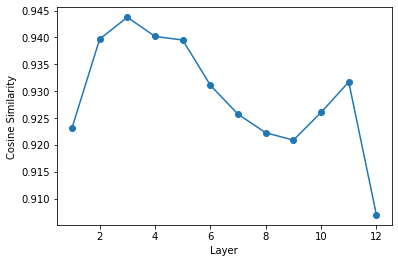

In [ ]:
# @title Other none-but token Similarities
other_but_sim = []
for layer in range(12):
  sim = []
  for ex in range(len(org_data)):
    if org_token_ids[ex][org_positions[ex]] != tokenizer.convert_tokens_to_ids('but'):
      continue
    if org_token_ids[ex][org_positions[ex]-1] == tokenizer.convert_tokens_to_ids(','):
      for i in range(1, org_positions[ex]-1):
        sim.append(cosine_similarity(org_hidden_representations[layer][ex][i].reshape(1,-1), inv_hidden_representations[layer][ex][i+inv_positions[ex]].reshape(1,-1)))
      
      sim.append(cosine_similarity(org_hidden_representations[layer][ex][org_positions[ex]-1].reshape(1,-1), inv_hidden_representations[layer][ex][inv_positions[ex]-1].reshape(1,-1)))

      for i in range(org_positions[ex]+1, np.sum(att_masks[ex])-2):
        sim.append(cosine_similarity(org_hidden_representations[layer][ex][i].reshape(1,-1), inv_hidden_representations[layer][ex][i-org_positions[ex]].reshape(1,-1)))

    else:
      for i in range(1, org_positions[ex]):
        sim.append(cosine_similarity(org_hidden_representations[layer][ex][i].reshape(1,-1), inv_hidden_representations[layer][ex][i+inv_positions[ex]].reshape(1,-1)))

      for i in range(org_positions[ex]+1, np.sum(att_masks[ex])-2):
        sim.append(cosine_similarity(org_hidden_representations[layer][ex][i].reshape(1,-1), inv_hidden_representations[layer][ex][i-org_positions[ex]].reshape(1,-1)))

    # period and [SEP]
    sim.append(cosine_similarity(org_hidden_representations[layer][ex][np.sum(att_masks[ex])-2].reshape(1,-1), inv_hidden_representations[layer][ex][np.sum(att_masks[ex])-2].reshape(1,-1)))
    sim.append(cosine_similarity(org_hidden_representations[layer][ex][np.sum(att_masks[ex])-1].reshape(1,-1), inv_hidden_representations[layer][ex][np.sum(att_masks[ex])-1].reshape(1,-1)))
    
  other_but_sim.append(np.mean(sim))
  

plt.plot(range(1, 13), other_but_sim, marker="o")
plt.xlabel("Layer")
plt.ylabel("Cosine Similarity")
plt.show()

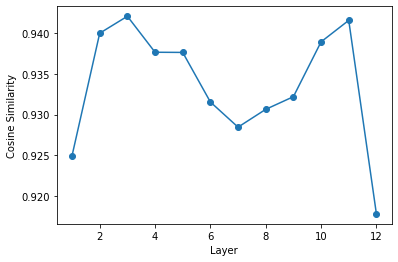

In [ ]:
# @title Other none-and token Similarities
other_and_sim = []
for layer in range(12):
  sim = []
  for ex in range(len(org_data)):
    if org_token_ids[ex][org_positions[ex]] != tokenizer.convert_tokens_to_ids('and'):
      continue
    if org_token_ids[ex][org_positions[ex]-1] == tokenizer.convert_tokens_to_ids(','):
      for i in range(1, org_positions[ex]-1):
        sim.append(cosine_similarity(org_hidden_representations[layer][ex][i].reshape(1,-1), inv_hidden_representations[layer][ex][i+inv_positions[ex]].reshape(1,-1)))
      
      sim.append(cosine_similarity(org_hidden_representations[layer][ex][org_positions[ex]-1].reshape(1,-1), inv_hidden_representations[layer][ex][inv_positions[ex]-1].reshape(1,-1)))

      for i in range(org_positions[ex]+1, np.sum(att_masks[ex])-2):
        sim.append(cosine_similarity(org_hidden_representations[layer][ex][i].reshape(1,-1), inv_hidden_representations[layer][ex][i-org_positions[ex]].reshape(1,-1)))

    else:
      for i in range(1, org_positions[ex]):
        sim.append(cosine_similarity(org_hidden_representations[layer][ex][i].reshape(1,-1), inv_hidden_representations[layer][ex][i+inv_positions[ex]].reshape(1,-1)))

      for i in range(org_positions[ex]+1, np.sum(att_masks[ex])-2):
        sim.append(cosine_similarity(org_hidden_representations[layer][ex][i].reshape(1,-1), inv_hidden_representations[layer][ex][i-org_positions[ex]].reshape(1,-1)))

    # period and [SEP]
    sim.append(cosine_similarity(org_hidden_representations[layer][ex][np.sum(att_masks[ex])-2].reshape(1,-1), inv_hidden_representations[layer][ex][np.sum(att_masks[ex])-2].reshape(1,-1)))
    sim.append(cosine_similarity(org_hidden_representations[layer][ex][np.sum(att_masks[ex])-1].reshape(1,-1), inv_hidden_representations[layer][ex][np.sum(att_masks[ex])-1].reshape(1,-1)))
    
  other_and_sim.append(np.mean(sim))
  

plt.plot(range(1, 13), other_and_sim, marker="o")
plt.xlabel("Layer")
plt.ylabel("Cosine Similarity")
plt.show()

##Importance Curves

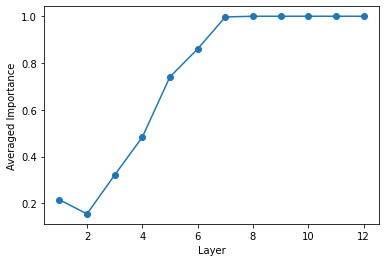

In [ ]:
# @title BUT Importance (NORMALIZED)
but_impo_norm = []
for layer in range(12):
  X = gold_importance[layer][total_token_ids == tokenizer.convert_tokens_to_ids('but')]
  but_impo_norm.append(np.mean(X / max_importance_per_layer[layer]))

plt.plot(range(1, 13), but_impo_norm, marker="o")
plt.xlabel("Layer")
plt.ylabel("Averaged Importance")
plt.show()

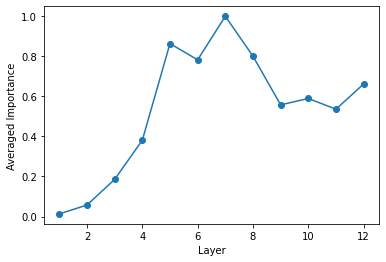

In [ ]:
# @title AND Importance (NORMALIZED)
and_impo_norm = []
for layer in range(12):
  X = gold_importance[layer][total_token_ids == tokenizer.convert_tokens_to_ids('and')]
  and_impo_norm.append(np.mean(X / max_importance_per_layer[layer]))

plt.plot(range(1, 13), and_impo_norm, marker="o")
plt.xlabel("Layer")
plt.ylabel("Averaged Importance")
plt.show()

##Integrating Plots

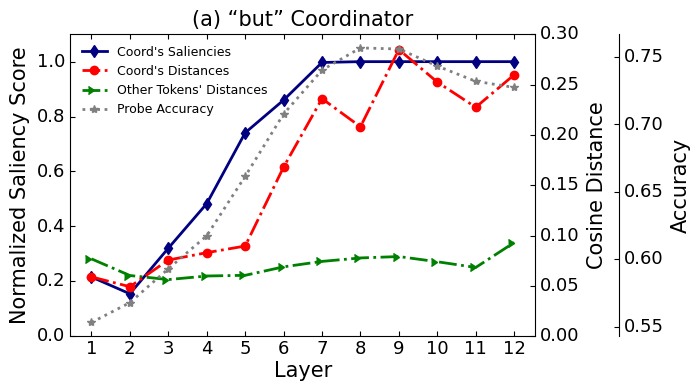

In [ ]:
#@title BUT
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13
linewidth = 2

but_dist = 1 - but_sim
and_dist = 1 - and_sim
other_but_dist = 1 - np.array(other_but_sim)

# plt.figure(dpi=100, figsize = (8,5))
plt.figure(dpi=100)
host = host_subplot(111, axes_class=AA.Axes) 
# plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 60
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))
par2.axis["right"].toggle(all=True)
par1.axis["right"].toggle(all=True)

host.set_xlabel("Layer")

host.plot(range(1, 13), but_impo_norm, c='navy', label="Coord's Saliencies", linestyle='solid', marker='d', linewidth=linewidth)
host.set_xlabel("Layer")
host.set_ylabel("Normalized Saliency Score")
host.set_xticks(range(13))
host.set_ylim(0, 1.1)


par1.plot(range(1, 13), but_dist, c='red', label="Coord's Distances", marker='o', linestyle='dashdot', linewidth=linewidth)
par1.plot(range(1, 13), other_but_dist, c='green', label="Other Tokens' Distances", marker=5, linestyle='dashdot', linewidth=linewidth)
par1.set_ylabel("Cosine Distance")
par1.set_ylim(0, 0.3)

par2.plot(range(1, 13), accuracy, c='gray', marker="*", linestyle='dotted', label="Probe Accuracy", linewidth=linewidth)
par2.set_ylabel("Accuracy")
# par2.set_ylim(0.5, 0.8)

host.axis["bottom"].label.set_fontsize(15)
host.axis["left"].label.set_fontsize(15)
par1.axis["right"].label.set_fontsize(15)
par2.axis["right"].label.set_fontsize(15)


host.legend(loc="upper left", prop={'size': 9}, frameon=False)
# plt.grid()

plt.title('(a) “but” Coordinator', fontsize=15)
# plt.title(r"""(a) "but" Coordinator""", fontsize=15)
fig.tight_layout()
plt.draw()
plt.show()

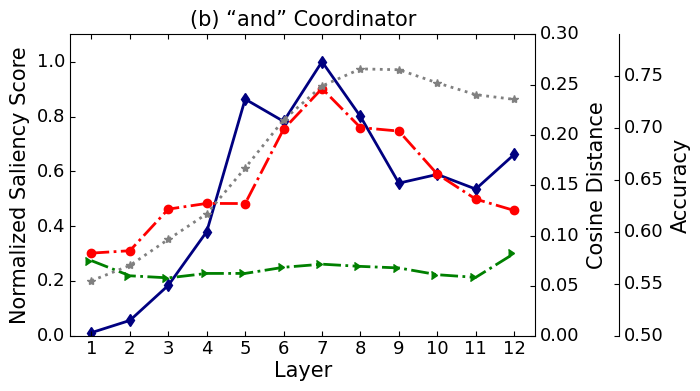

In [ ]:
# @title AND
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
linewidth = 2

but_dist = 1 - but_sim
and_dist = 1 - and_sim
other_and_dist = 1 - np.array(other_and_sim)

# plt.figure(dpi=100, figsize = (8,5))
plt.figure(dpi=100)
host = host_subplot(111, axes_class=AA.Axes) 
# plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 60
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))
par2.axis["right"].toggle(all=True)
par1.axis["right"].toggle(all=True)

host.set_xlabel("Layer")

host.plot(range(1, 13), and_impo_norm, c='navy', label="Normalized Saliency Scores", linestyle='solid', marker='d', linewidth=linewidth)
host.set_xlabel("Layer")
host.set_ylabel("Normalized Saliency Score")
host.set_xticks(range(13))
host.set_ylim(0, 1.1)

par1.plot(range(1, 13), and_dist, c='red', label="And Distances", marker='o', linestyle='dashdot', linewidth=linewidth)
par1.plot(range(1, 13), other_and_dist, c='green', label="Other Token Distances", marker=5, linestyle='dashdot', linewidth=linewidth)
par1.set_ylabel("Cosine Distance")
par1.set_ylim(0, 0.3)

par2.plot(range(1, 13), accuracy, c='gray', linestyle='dotted', marker="*", label="Task Accuracy", linewidth=linewidth)
par2.set_ylabel("Accuracy")
par2.set_ylim(0.5, 0.79)

host.axis["bottom"].label.set_fontsize(15)
host.axis["left"].label.set_fontsize(15)
par1.axis["right"].label.set_fontsize(15)
par2.axis["right"].label.set_fontsize(15)

# host.legend()
# plt.legend(bbox_to_anchor=(1.3, 1), loc='upper left', borderaxespad=0.)
# plt.grid()
plt.title('(b) “and” Coordinator', fontsize=15)
fig.tight_layout()
plt.draw()
plt.show()